# Location Recommendation for a New Business Unit

# Battle of Neighborhoods

##### Installing beautifulsoup4, lxml, geocoder, html5lib, fo

In [1]:
#!conda install -c conda-beautifulsoup4 lxml --yes

In [2]:
#!conda install -c conda-forge lxml --yes

In [3]:
#!conda install -c conda-forge geocoder --yes

In [4]:
#!conda install -c conda-forge html5lib --yes

In [5]:
#!conda install -c conda-forge folium=0.5.0 --yes 

#### Importing the required libraries

In [1]:

from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#seaborn
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#### Extract the demographic information of Toronto Neighbourhoods from wikipedia link: https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods

In [3]:
res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')
demographics_table = soup.find_all('table') 
Demographics_df= pd.read_html(str(demographics_table[1]), index_col=None, header=0)[0]

In [4]:
Demographics_df.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [5]:

Demographics_df.shape

(175, 13)

In [6]:
Demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 13 columns):
Name                                                         175 non-null object
FM                                                           174 non-null object
Census Tracts                                                175 non-null object
Population                                                   175 non-null int64
Land area (km2)                                              175 non-null float64
Density (people/km2)                                         175 non-null int64
% Change in Population since 2001                            175 non-null float64
Average Income                                               175 non-null object
Transit Commuting %                                          175 non-null float64
% Renters                                                    175 non-null float64
Second most common language (after English) by name          174 non-null object
Se

In [7]:
Demographics_df.shape

(175, 13)

In [8]:
Demographics_df.columns

Index(['Name', 'FM', 'Census Tracts', 'Population', 'Land area (km2)',
       'Density (people/km2)', '% Change in Population since 2001',
       'Average Income', 'Transit Commuting %', '% Renters',
       'Second most common language (after English) by name',
       'Second most common language (after English) by percentage', 'Map'],
      dtype='object')

#### Data Cleaning

##### Drop the 1st row as it represents the overall demographics of Toronto

In [9]:
Demographics_df.drop(index=0, inplace=True)
Demographics_df.reset_index(drop=True, inplace=True)
Demographics_df.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
1,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
2,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
3,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN
4,Amesbury,NY,"0280.00, 0281.01, 0281.02",17318,3.51,4934,1.1,27546,16.4,19.7,Spanish (6.1%),06.1% Spanish,NaN


##### Drop the columns ( 'FM', 'Census Tracts', 'Average Income','% Renters', '% Change in Population since 2001','Second most common language (after English) by name', 'Map') that are not required to address the business statement

In [10]:
Demographics_df.drop(labels = ['FM', 'Census Tracts', 'Average Income', '% Renters', '% Change in Population since 2001','Second most common language (after English) by name', 'Map'], axis=1, inplace=True)

##### Renaming of columns

In [11]:
Demographics_df.rename({'Second most common language (after English) by percentage': 'Language', 'Name':'Neighbourhood'}, inplace = True, axis = 1)

In [12]:
#Demographics_df.sort_values(by=['Name'])
Demographics_df = Demographics_df[['Neighbourhood', 'Population', 'Density (people/km2)', 'Language']]

##### Split the language column into two columns, i.e. Language and Percentage

In [13]:
language_info = Demographics_df['Language'].str.split(" ", n = 1, expand = True) 
Demographics_df['Language Percentage'] = language_info[0]
Demographics_df['Language'] = language_info[1]

Demographics_df.head()

,Neighbourhood,Population,Density (people/km2),Language,Language Percentage
0,Agincourt,44577,3580,Cantonese,19.3%
1,Alderwood,11656,2360,Polish,06.2%
2,Alexandra Park,4355,13609,Cantonese,17.9%
3,Allenby,2513,4333,Russian,01.4%
4,Amesbury,17318,4934,Spanish,06.1%


In [14]:
Demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 5 columns):
Neighbourhood           174 non-null object
Population              174 non-null int64
Density (people/km2)    174 non-null int64
Language                174 non-null object
Language Percentage     174 non-null object
dtypes: int64(2), object(3)
memory usage: 6.9+ KB


##### Check the data type of the 'Language Percentage' column and convert it into float

In [15]:
Demographics_df['Language Percentage'].dtypes

dtype('O')

In [16]:
Demographics_df['Language Percentage'] = Demographics_df['Language Percentage'].str.split('%',n = 1, expand = True)[0]

In [17]:
Demographics_df['Language Percentage']= Demographics_df['Language Percentage'].astype(float)

### Exploratory Data Analysis

#### Let us check the Top 10 most populated Neighbourhoods

In [18]:
top10_df = Demographics_df.sort_values(['Population', 'Density (people/km2)'], ascending=False)
top10_df.reset_index(drop=True,inplace=True)
top10_df.head()

,Neighbourhood,Population,Density (people/km2),Language,Language Percentage
0,Old East York,52220,6577,Greek,4.3
1,Woburn,48507,3636,Gujarati,9.1
2,Elia (Jane and Finch),48003,6267,Vietnamese,6.9
3,L'Amoreaux,45862,6414,Unspecified Chinese,13.9
4,Agincourt,44577,3580,Cantonese,19.3


In [19]:
xlabels = top10_df['Neighbourhood'][:10]

<Figure size 432x288 with 0 Axes>

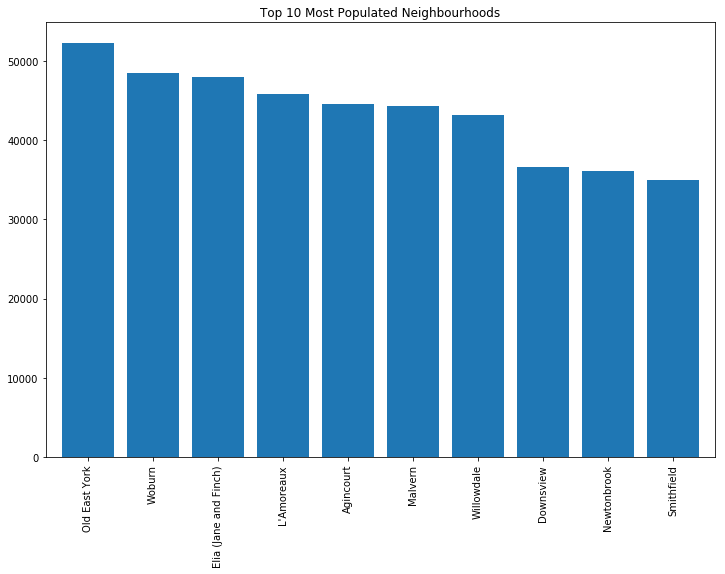

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
ax = top10_df[['Population']][:10].plot(kind='bar', figsize=(12, 8), legend=False, fontsize=10, width=0.8)
ax.set_xticklabels(xlabels, fontsize=10)
plt.title('Top 10 Most Populated Neighbourhoods')
plt.show()

#### Let us now obtain the count plot for Second Most Popular Language (after English) in Different Neighbourhoods of Toronto

In [21]:
vb = pd.DataFrame(Demographics_df.groupby('Language').count()) #sort_values()
vb.sort_values(by = 'Neighbourhood',ascending=False, inplace=True)
vb['Neighbourhood'][0:10]

Language
Portuguese             23
Unspecified Chinese    20
Cantonese              16
Polish                 12
Tamil                  12
Filipino               11
Spanish                11
Italian                10
Russian                 9
Ukrainian               7
Name: Neighbourhood, dtype: int64

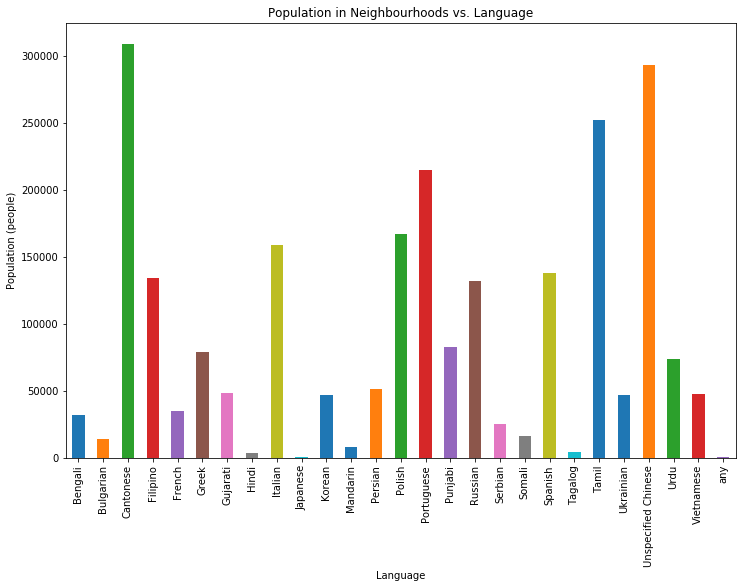

In [22]:
Demographics_df.groupby(['Language']).sum().plot(y='Population',kind='bar',figsize=(12,8),legend=False)
plt.xlabel('Language')
plt.ylabel('Population (people)')
plt.title('Population in Neighbourhoods vs. Language')
plt.show()

#### The above results shows that 'Portuguese'is the most popular language and out of all the Indian languages, 'Tamil' is the most popular language 

######                 

#### Neighbourhoods with Indian Languages

In [23]:
Indian_lang = [ 'Bengali','Gujarati', 'Hindi', 'Punjabi','Tamil']

#### Series with only Indian languages

In [24]:
lang = Demographics_df[Demographics_df['Language'].isin(Indian_lang)]['Language']
type(lang)

pandas.core.series.Series

In [25]:
lang.groupby(Demographics_df['Language']).count()

Language
Bengali      3
Gujarati     1
Hindi        1
Punjabi      5
Tamil       12
Name: Language, dtype: int64

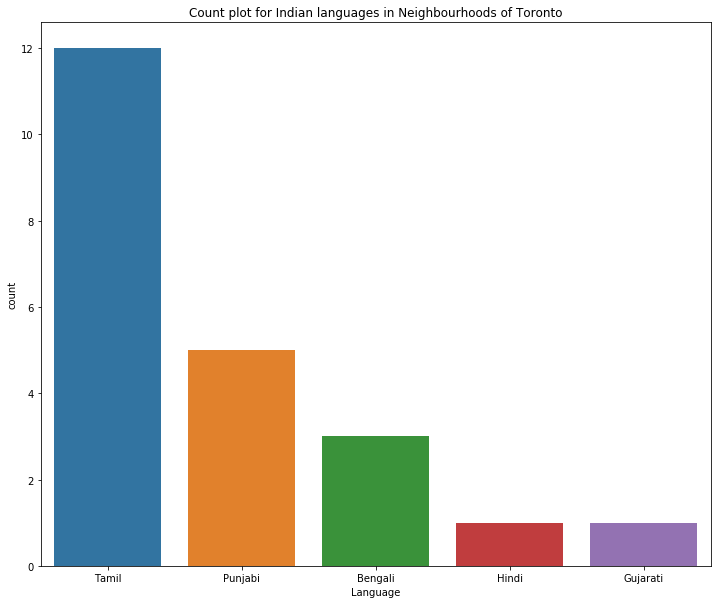

In [26]:
plt.figure(figsize = (12,10))
sns.countplot(x = lang, data=Demographics_df)
plt.title('Count plot for Indian languages in Neighbourhoods of Toronto')
plt.show()

#### Create the dataframe containing only Indian Language Neighbourhoods

In [27]:
Indian_df = Demographics_df[Demographics_df['Language'].isin(Indian_lang)]
Indian_df.reset_index(drop=True, inplace=True)
Indian_df.sort_values(by = 'Density (people/km2)', ascending=False, inplace=True)
Indian_df.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighbourhood,Population,Density (people/km2),Language,Language Percentage
3,Crescent Town,8157,20393,Bengali,18.1
13,Regent Park/Trefann Court,10387,16230,Bengali,10.5
12,Oakridge,13368,7187,Bengali,12.6
5,Eglinton East,22387,6931,Tamil,9.7
16,Scarborough City Centre,16403,6358,Tamil,10.3


#### Plots for population of Toronto Neighbourhoods with different Indian Languages

In [28]:
Indian_df.groupby(['Language']).sum()

,Population,Density (people/km2),Language Percentage
Language,,,
Bengali,31912,43810,41.2
Gujarati,48507,3636,9.1
Hindi,3821,1794,1.7
Punjabi,82389,14741,68.8
Tamil,252036,46971,97.0


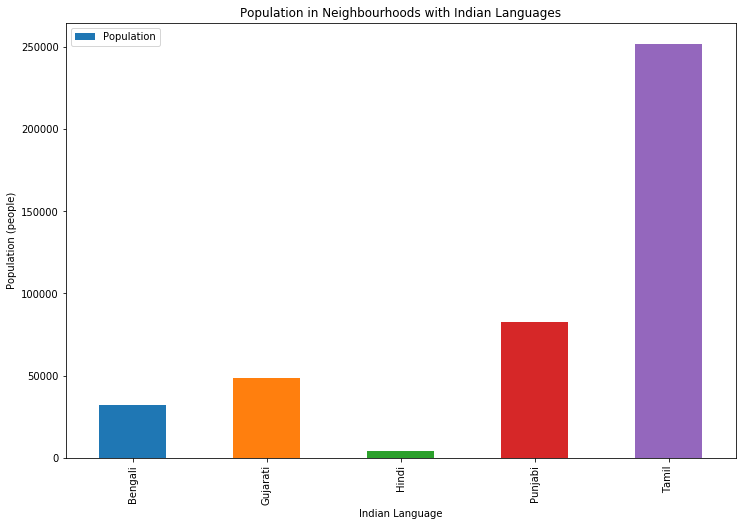

In [29]:
Indian_df.groupby(['Language']).sum().plot(y='Population',kind='bar',figsize=(12,8))
plt.xlabel('Indian Language')
plt.ylabel('Population (people)')
plt.title('Population in Neighbourhoods with Indian Languages')
plt.show()

##### From the above plot, it is evident that the population of Tamil speaking people is the highest, followed by Punjabis and Bengalis. (among neighbourhoods with Indian languages)

#### Plot for population density of Toronto Neighbourhoods with different Indian Languages

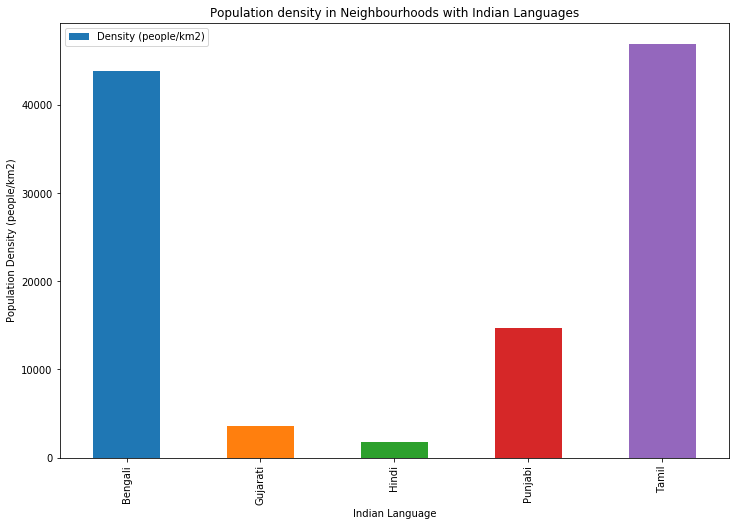

In [30]:
Indian_df.groupby(['Language']).sum().plot(y='Density (people/km2)',kind='bar',figsize=(12,8))
plt.xlabel('Indian Language')
plt.ylabel('Population Density (people/km2)')
plt.title('Population density in Neighbourhoods with Indian Languages')
plt.show()

##### From the above plot, it appears that Bengali Neighbourhoods are densely populated, followed by Tamil and Punjabi Neighbourhoods

#### Scrape and Extract the required information from the webpage: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [31]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

In [32]:
toronto_pc= soup.find('table')                                #find the tablular column containing the required information
toronto_pc = toronto_pc.find('tbody')

toronto_pclist =[]                                            #create an empty list to store the extracted data

rows = toronto_pc.find_all('tr')                              #find all the rows in the table
for row in rows:
    cols = row.find_all('td')
    cols = [entry.text.strip() for entry in cols]             #extract the required text corresponding to each column
    toronto_pclist.append([entry for entry in cols if entry]) #append the data to the list

col_name = toronto_pc.find_all('th')                          #extract the column names
toronto_pclist[0] = [col.text.strip() for col in col_name]    #column names for the final dataframe


### Required dataframe

In [33]:
toronto_df = pd.DataFrame(toronto_pclist)   #convert the list to a dataframe
toronto_df.columns = toronto_df.iloc[0]     #name the columns
toronto_df.drop(0, inplace=True)            #drop the first row with column names
toronto_df.head()

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


#### Basic information about the dataframe

In [34]:
toronto_df.shape

(289, 3)

In [35]:
toronto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 1 to 289
Data columns (total 3 columns):
Postcode         289 non-null object
Borough          289 non-null object
Neighbourhood    289 non-null object
dtypes: object(3)
memory usage: 9.0+ KB


#### Cleaning Stage

#### Replace the 'Not assigned' neighbourhoods with the name of the corresponding Borough

In [36]:
#assign the corresponding Borough Name for 'not assigned neighbourhoods'
toronto_df.loc[toronto_df['Neighbourhood'].eq('Not assigned'),'Neighbourhood'] = toronto_df.loc[toronto_df['Neighbourhood'].eq('Not assigned'),'Borough']
toronto_df.head()


,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


#### Drop all the rows with 'not assigned' neighbourhoods

In [37]:
toronto_df = toronto_df[toronto_df['Neighbourhood']!='Not assigned']  
toronto_df.reset_index(drop=True, inplace=True)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


#### Check the number of rows in the resulting frame

In [38]:
print('Number of rows in the dataframe after cleaning: ',toronto_df.shape[0])

Number of rows in the dataframe after cleaning:  212


#### Merge the two dataframes (toronto_df, Demographics_df)

In [39]:
new_df3 = pd.merge(toronto_df, Demographics_df,  left_on='Neighbourhood', right_on='Neighbourhood')
print('Number of rows in the merged dataframe: ', new_df3.shape[0])


Number of rows in the merged dataframe:  79


In [40]:
new_df3.head()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage
0,M3A,North York,Parkwoods,26533,5349,Unspecified Chinese,3.4
1,M4A,North York,Victoria Village,17047,3612,Urdu,3.2
2,M6A,North York,Lawrence Heights,3769,1178,Italian,15.0
3,M6A,North York,Lawrence Manor,13750,6425,Filipino,7.2
4,M1B,Scarborough,Rouge,22724,791,Tamil,15.6


In [41]:
new_df3.groupby('Language').count()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language Percentage
Language,,,,,,
Bengali,1,1,1,1,1,1
Bulgarian,1,1,1,1,1,1
Cantonese,8,8,8,8,8,8
Filipino,10,10,10,10,10,10
French,4,4,4,4,4,4
Greek,1,1,1,1,1,1
Gujarati,1,1,1,1,1,1
Italian,3,3,3,3,3,3
Korean,2,2,2,2,2,2


####  Dataframe with geospatial coordinates for all the Neighbourhoods

##### Get the dataframe with the geospatial coordinates from https://cocl.us/Geospatial_data

In [42]:
geo_coord = pd.read_csv('Geospatial_Coordinates.csv') # read the csv file containing the geospatial coordinates
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [43]:
geo_coord.shape

(103, 3)

##### Merge the dataframes (new_df3 and geo_coord) to include Latitude and Longitude columns

In [44]:
toronto_df = pd.merge(new_df3, geo_coord, how='inner', left_on='Postcode', right_on = 'Postal Code')
toronto_df.drop('Postal Code', axis =1, inplace = True)
toronto_df.head(10)

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage,Latitude,Longitude
0,M3A,North York,Parkwoods,26533,5349,Unspecified Chinese,3.4,43.753259,-79.329656
1,M4A,North York,Victoria Village,17047,3612,Urdu,3.2,43.725882,-79.315572
2,M6A,North York,Lawrence Heights,3769,1178,Italian,15.0,43.718518,-79.464763
3,M6A,North York,Lawrence Manor,13750,6425,Filipino,7.2,43.718518,-79.464763
4,M1B,Scarborough,Rouge,22724,791,Tamil,15.6,43.806686,-79.194353
5,M1B,Scarborough,Malvern,44324,5003,Tamil,12.2,43.806686,-79.194353
6,M5B,Downtown Toronto,Garden District,8240,15846,Unspecified Chinese,3.0,43.657162,-79.378937
7,M9B,Etobicoke,Princess Gardens,9288,2249,Korean,2.4,43.650943,-79.554724
8,M9B,Etobicoke,West Deane Park,4395,2063,Ukrainian,2.3,43.650943,-79.554724
9,M1C,Scarborough,Highland Creek,12853,2505,Tamil,5.1,43.784535,-79.160497


In [45]:
toronto_df.shape

(79, 9)

In [46]:
Indian_df = toronto_df[toronto_df['Language'].isin(Indian_lang)]
Indian_df.reset_index(drop=True, inplace=True)
Indian_df.sort_values(by = 'Density (people/km2)', ascending=False, inplace=True)
Indian_df.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage,Latitude,Longitude
7,M1L,Scarborough,Oakridge,13368,7187,Bengali,12.6,43.711112,-79.284577
6,M1J,Scarborough,Scarborough Village,12796,6303,Tamil,11.4,43.744734,-79.239476
1,M1B,Scarborough,Malvern,44324,5003,Tamil,12.2,43.806686,-79.194353
10,M9V,Etobicoke,Thistletown,16790,4229,Punjabi,8.6,43.739416,-79.588437
3,M1E,Scarborough,Morningside,11472,4112,Tamil,10.8,43.763573,-79.188711


#### Step 3: Segmenting and Clustering the neighbourhoods in Downtown Toronto

In [47]:
# get the coordinates for Toronto
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [48]:
# Neighbourhoods in Toronto

map_toronto = folium.Map(location = [latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

##### Foursquare credentials and version

In [49]:
CLIENT_ID = '0Y4BBJKM3PM5SE1WCEPHJZXKV1BWJHJA5LYE15PGNBLOYHOZ' # your Foursquare ID
CLIENT_SECRET = '2VVLHBL4BSGSPN35SWA120KIENZHHWXNZPWROWSWJOID3BAD' # your Foursquare Secret
VERSION = '20190201' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0Y4BBJKM3PM5SE1WCEPHJZXKV1BWJHJA5LYE15PGNBLOYHOZ
CLIENT_SECRET:2VVLHBL4BSGSPN35SWA120KIENZHHWXNZPWROWSWJOID3BAD


In [50]:
LIMIT = 100
radius = 500

#### Explore the first neighbourhood (Parkwoods)

In [51]:
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Get the top 100 venues that are in Parkwoods within a radius of 500 meters.

In [52]:
# GET request url
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0Y4BBJKM3PM5SE1WCEPHJZXKV1BWJHJA5LYE15PGNBLOYHOZ&client_secret=2VVLHBL4BSGSPN35SWA120KIENZHHWXNZPWROWSWJOID3BAD&v=20190201&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [53]:
# send the GET request and examine the results
results = requests.get(url).json()
results['response']['groups'][0]['items']

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
   'name': 'Brookbanks Park',
   'location': {'address': 'Toronto',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.751976046055574,
      'lng': -79.33214044722958}],
    'distance': 245,
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
   'categories': [{'id': '4bf58dd8d48988d163941735',
     'name': 'Park',
     'pluralName': 'Parks',
     'shortName': 'Park',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-4e8d9dcdd5fbbbb6b3003c7b-0'},
 {'reasons': {'count': 0,
   'items': [{'

In [54]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Explore venues in the first neighbourhood (Parkwoods)

In [55]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [56]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


#### Explore and get nearby venues for all the neighbourhoods in Toronto

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
# venues for the neighbourhoods in Toronto

toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )



Parkwoods
Victoria Village
Lawrence Heights
Lawrence Manor
Rouge
Malvern
Garden District
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
St. James Town
St. James Town
Cabbagetown
Eringate
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Leaside
Bathurst Manor
Wilson Heights
Thorncliffe Park
Scarborough Village
Henry Farm
Toronto Islands
Little Portugal
Ionview
Bayview Village
Riverdale
Brockton
Clairlea
Oakridge
York Mills
Humber Summit
Cliffcrest
Cliffside
Newtonbrook
Willowdale
Bedford Park
Mount Dennis
Silverthorn
Humberlea
Birch Cliff
Lawrence Park
Runnymede
Runnymede
Swansea
Weston
Dorset Park
Westmount
Maryvale
Wexford
The Annex
Yorkville
Parkdale
Roncesvalles
Kingsview Village
Agincourt
Davisville
Moore Park
Grange Park
Kensington Market
Milliken
Deer Park
South Hill
Humber Bay Shores
New Toronto
Thistletown
Rosedale
Alderwood
Long Branch
The Kingsway
Church and Wellesley
Sunnylea


In [60]:
print(toronto_venues.shape)
toronto_venues.head()

(1446, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


##### Number of venues in each neighbourhood

In [61]:
toronto_venues.groupby('Neighbourhood').count() #.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
Alderwood,8,8,8,8,8,8
Bathurst Manor,17,17,17,17,17,17
Bayview Village,4,4,4,4,4,4
Bedford Park,25,25,25,25,25,25
Birch Cliff,4,4,4,4,4,4
Brockton,18,18,18,18,18,18
Cabbagetown,46,46,46,46,46,46
Church and Wellesley,86,86,86,86,86,86


In [62]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 222 unique categories.


#### Analyze each neighbourhood

In [63]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1446, 223)


,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Group neighbourhoods and take the mean of the frequency of occurence of each venue

In [64]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0

In [65]:
toronto_grouped.shape

(74, 223)

#### Top 5 most frequent venues in each neighbourhood

In [66]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
               venue  freq
0     Breakfast Spot  0.25
1       Skating Rink  0.25
2             Lounge  0.25
3     Sandwich Place  0.25
4  Accessories Store  0.00


----Alderwood----
            venue  freq
0     Pizza Place  0.25
1  Sandwich Place  0.12
2        Pharmacy  0.12
3     Coffee Shop  0.12
4    Skating Rink  0.12


----Bathurst Manor----
                  venue  freq
0           Coffee Shop  0.12
1    Frozen Yogurt Shop  0.06
2        Sandwich Place  0.06
3      Sushi Restaurant  0.06
4  Fast Food Restaurant  0.06


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2   Chinese Restaurant  0.25
3                 Bank  0.25
4    Accessories Store  0.00


----Bedford Park----
                  venue  freq
0           Pizza Place  0.08
1           Coffee Shop  0.08
2  Fast Food Restaurant  0.08
3    Italian Restaurant  0.08
4     Indian Restaurant  0.04


----Birch Cliff----
                   venue  

#### Create a dataframe listing the top 10 most frequent venues for each neighbourhood

In [67]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Sandwich Place,Breakfast Spot,Skating Rink,Lounge,Yoga Studio,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
1,Alderwood,Pizza Place,Gym,Pharmacy,Coffee Shop,Pub,Sandwich Place,Skating Rink,Empanada Restaurant,Ethiopian Restaurant,Event Space
2,Bathurst Manor,Coffee Shop,Pharmacy,Diner,Restaurant,Sandwich Place,Bank,Frozen Yogurt Shop,Fried Chicken Joint,Grocery Store,Sushi Restaurant
3,Bayview Village,Bank,Café,Japanese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop
4,Bedford Park,Fast Food Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Juice Bar,Thai Restaurant,Butcher,Sandwich Place,Restaurant,Liquor Store


#### Perform clustering using k-means

##### Find the optimum k value

In [69]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

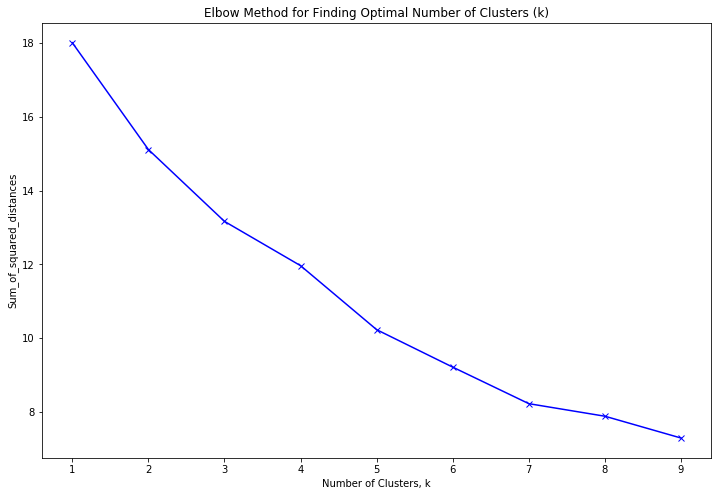

In [70]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.figure(figsize=(12,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Finding Optimal Number of Clusters (k)')
plt.show()

##### From the above plot, we can say that the optimal k value is 5.

In [71]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 4, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Dataframe with cluster number and top 10 venues for each neighbourhood

In [72]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,26533,5349,Unspecified Chinese,3.4,43.753259,-79.329656,0.0,Food & Drink Shop,Fast Food Restaurant,Park,Yoga Studio,Empanada Restaurant,Food Court,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
1,M4A,North York,Victoria Village,17047,3612,Urdu,3.2,43.725882,-79.315572,0.0,Coffee Shop,Pizza Place,Portuguese Restaurant,Hockey Arena,Electronics Store,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
2,M6A,North York,Lawrence Heights,3769,1178,Italian,15.0,43.718518,-79.464763,0.0,Accessories Store,Coffee Shop,Miscellaneous Shop,Boutique,Furniture / Home Store,Shoe Store,Event Space,Gift Shop,Clothing Store,Vietnamese Restaurant
3,M6A,North York,Lawrence Manor,13750,6425,Filipino,7.2,43.718518,-79.464763,0.0,Accessories Store,Coffee Shop,Miscellaneous Shop,Boutique,Furniture / Home Store,Shoe Store,Event Space,Gift Shop,Clothing Store,Vietnamese Restaurant
4,M1B,Scarborough,Rouge,22724,791,Tamil,15.6,43.806686,-79.194353,1.0,Fast Food Restaurant,Yoga Studio,Ethiopian Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant


In [73]:
toronto_merged.dropna(how ='any', inplace = True)

In [74]:
toronto_merged['Cluster Labels'].unique()

array([0., 1., 4., 2., 3.])

In [75]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [76]:
toronto_merged.columns

Index(['Postcode', 'Borough', 'Neighbourhood', 'Population',
       'Density (people/km2)', 'Language', 'Language Percentage', 'Latitude',
       'Longitude', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

#### Map showing the clusters

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine the clusters

In [78]:
toronto_merged.columns[[1,2,3,4,5] + list(range(9,toronto_merged.shape[1]))] #range()]

Index(['Borough', 'Neighbourhood', 'Population', 'Density (people/km2)',
       'Language', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

In [79]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [80]:
cluster_0.shape

(67, 16)

In [81]:
#cluster_0.groupby('Language Percentage').count()
cluster_0.groupby(['Language', 'Neighbourhood','Borough','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']).count()

Population  \
Language            Neighbourhood        Borough          1st Most Common Venue     2nd Most Common Venue     3rd Most Common Venue                   
Bengali             Oakridge             Scarborough      Bus Line                  Bakery                    Metro Station                       1   
Bulgarian           Leaside              East York        Coffee Shop               Sporting Goods Shop       Burger Joint                        1   
Cantonese           Agincourt            Scarborough      Sandwich Place            Breakfast Spot            Skating Rink                        1   
                    Bayview Village      North York       Bank                      Café                      Japanese Restaurant                 1   
                    Kensington Market    Downtown Toronto Café                      Bar                       Vietnamese Restaurant               1   
                    Milliken             Scarborough      Playground                Park                      Yoga Studio                         1   
                    Riverdale            East Toronto     Greek Restaurant          Coffee Shop               Ice Cream Shop                      1   
                    The Beaches          East Toronto     Coffee Shop               Pub                       Asian Restaurant                    1   
Filipino            Clairlea             Scarborough      Bus Line                  Bakery                    Metro Station                       1   
                    Ionview              Scarborough      Discount Store            Department Store          Train Station                       1   
                    Lawrence Manor       North York       Accessories Store         Coffee Shop               Miscellaneous Shop                  1   
                    Maryvale             Scarborough      Middle Eastern Restaurant Breakfast Spot            Shopping Mall                       1   
                    St. James Town       Downtown Toronto Coffee Shop               Restaurant                Café                                2   
                    Wexford              Scarborough      Middle Eastern Restaurant Breakfast Spot            Shopping Mall                       1   
                    Wilson Heights       North York       Coffee Shop               Pharmacy                  Diner                               1   
French              Lawrence Park        Central Toronto  Lake                      Bus Line                  Dim Sum Restaurant                  1   
                    Moore Park           Central Toronto  Playground                Trail                     Empanada Restaurant                 1   
                    South Hill           Central Toronto  Coffee Shop               Pub                       Fried Chicken Joint                 1   
                    Yorkville            Central Toronto  Coffee Shop               Sandwich Place            Café                                1   
Greek               Bedford Park         North York       Fast Food Restaurant      Pizza Place               Coffee Shop                         1   
Gujarati            Woburn               Scarborough      Coffee Shop               Insurance Office          Convenience Store                   1   
Italian             Humber Summit        North York       Empanada Restaurant       Pizza Place               Yoga Studio                         1   
                    Humberlea            North York       Furniture / Home Store    Baseball Field            Yoga Studio                         1   
                    Lawrence Heights     North York       Accessories Store         Coffee Shop               Miscellaneous Shop                  1   
Mandarin            Henry Farm           North York       Clothing Store            Fast Food Restaurant      Coffee Shop                         1   
Persian             Davisville           Central Toronto  De

#### Examine the neighbourhoods with Indian Languages

In [85]:
cluster_0[cluster_0['Language']=='Tamil']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Scarborough,Morningside,11472,4112,Tamil,0,Medical Center,Breakfast Spot,Rental Car Location,Electronics Store,Mexican Restaurant,Pizza Place,Hobby Shop,Hospital,Food,Fish Market
20,Scarborough,West Hill,25632,2676,Tamil,0,Medical Center,Breakfast Spot,Rental Car Location,Electronics Store,Mexican Restaurant,Pizza Place,Hobby Shop,Hospital,Food,Fish Market
27,Scarborough,Scarborough Village,12796,6303,Tamil,0,Playground,Spa,Dance Studio,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
53,Scarborough,Dorset Park,14189,3331,Tamil,0,Indian Restaurant,Latin American Restaurant,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Yoga Studio,Food Court,Food & Drink Shop,Food,Fish Market


In [86]:
cluster_0[cluster_0['Language']=='Bengali']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Scarborough,Oakridge,13368,7187,Bengali,0,Bus Line,Bakery,Metro Station,Soccer Field,Bus Station,Park,Intersection,Fast Food Restaurant,Falafel Restaurant,Food Court


In [87]:
cluster_0[cluster_0['Language']=='Punjabi']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,Etobicoke,Thistletown,16790,4229,Punjabi,0,Grocery Store,Pizza Place,Fried Chicken Joint,Coffee Shop,Beer Store,Fast Food Restaurant,Pharmacy,Sandwich Place,Fish & Chips Shop,Filipino Restaurant


In [88]:
cluster_0[cluster_0['Language']=='Gujarati']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Scarborough,Woburn,48507,3636,Gujarati,0,Coffee Shop,Insurance Office,Convenience Store,Korean Restaurant,Yoga Studio,Ethiopian Restaurant,Food Court,Food & Drink Shop,Food,Fish Market


In [89]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [90]:
cluster_1.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Scarborough,Rouge,22724,791,Tamil,1,Fast Food Restaurant,Yoga Studio,Ethiopian Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
5,Scarborough,Malvern,44324,5003,Tamil,1,Fast Food Restaurant,Yoga Studio,Ethiopian Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant


In [91]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [92]:
cluster_2.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Scarborough,Highland Creek,12853,2505,Tamil,2,Bar,Yoga Studio,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
10,Scarborough,Rouge Hill,11167,2878,Filipino,2,Bar,Yoga Studio,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
11,Scarborough,Port Union,12450,2310,Filipino,2,Bar,Yoga Studio,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant


In [93]:
cluster_3 =toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [94]:
cluster_3.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Scarborough,Cliffcrest,14531,2073,Tamil,3,American Restaurant,Motel,Yoga Studio,Ethiopian Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant
40,Scarborough,Cliffside,9386,3831,Cantonese,3,American Restaurant,Motel,Yoga Studio,Ethiopian Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant


In [95]:
cluster_4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [96]:
cluster_4.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Etobicoke,Princess Gardens,9288,2249,Korean,4,Bank,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
8,Etobicoke,West Deane Park,4395,2063,Ukrainian,4,Bank,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


##### From the above result, we can observe that 'Dorset Park' neighbourhood includes relatively more number of restaurants.  The business statement requires a location with restaurants in the vicinity. So this neighbourhood can be considered for opening our new business unit.

#### Results corresponding to 'Dorset Park' Neighbourhood

In [97]:
cluster_0[cluster_0['Neighbourhood']=='Dorset Park']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Scarborough,Dorset Park,14189,3331,Tamil,0,Indian Restaurant,Latin American Restaurant,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Yoga Studio,Food Court,Food & Drink Shop,Food,Fish Market
